In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
np.set_printoptions(precision=2, linewidth=120)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
d = 0.01

In [4]:
PDIAG = np.zeros((9, 9))
for esi in np.eye(3):
    one = np.kron(esi, esi)
    PDIAG = PDIAG + np.outer(one, one)
PDIAG = PDIAG.astype(np.int)

def Ls(d=0.1):
    L1 = np.array([[np.cos(d), -np.sin(d), 0],
                   [np.sin(d), np.cos(d), 0],
                   [0, 0, 1]])
    L2 = np.roll(np.roll(L1, 1, axis=0), 1, axis=1)
    L3 = np.roll(np.roll(L2, 1, axis=0), 1, axis=1)
    return L1, L2, L3

def SENSOR(d=0.1):
    L1, L2, L3 = Ls(d)
    LL1 = np.dot(PDIAG, np.kron(L1, L1))
    LL2 = np.dot(PDIAG, np.kron(L2, L2))
    LL3 = np.dot(PDIAG, np.kron(L3, L3))
    SENSOR = np.r_[LL1[[0, 4, 8], :], LL2[[0, 4, 8], :], LL3[[0, 4, 8], :]]
    SENSOR = SENSOR[:, [0, 1, 2, 4, 5, 8]]
    return SENSOR

def sample(c, n, d):
    C = np.dot(np.dot(c["Q"], np.diag([c["kx"], c["ky"], c["kz"]])), c["Q"].T)
    cvec = np.reshape(C, (9, 1))
    cvec = cvec[[0, 1, 2, 4, 5, 8], :]
    rates = np.dot(SENSOR(d), cvec).T[0]
    
    # Get samples for each L_i
    N1 = np.random.multinomial(n, rates[0:3])
    N2 = np.random.multinomial(n, rates[3:6])
    N3 = np.random.multinomial(n, rates[6:9])
    
    # Recover some coefficients
    D1 = N1 / float(n)
    D2 = N2 / float(n)
    D3 = N3 / float(n)
    
    data = np.r_[D1, D2, D3]
    return data

def perfect_data(c, n, d):
    C = np.dot(np.dot(c["Q"], np.diag([c["kx"], c["ky"], c["kz"]])), c["Q"].T)
    cvec = np.reshape(C, (9, 1))
    cvec = cvec[[0, 1, 2, 4, 5, 8], :]
    data = np.dot(SENSOR(d), cvec).T[0]
    return data

def recoverM(data, d):
    # Linear constraint on trace
    # R * m = data
    # extend m by one variable x = [m; z1]
    # http://stanford.edu/class/ee103/lectures/constrained-least-squares/constrained-least-squares_slides.pdf
    TRACE = np.array([[1, 0, 0, 1, 0, 1]])
    R = np.r_[2.0 * np.dot(SENSOR(d).T, SENSOR(d)), TRACE]
    R = np.c_[R, np.r_[TRACE.T, [[0]]]]
    Y = np.r_[2.0*np.dot(SENSOR(d).T, data), 1]
    m = np.dot(np.dot(np.linalg.inv(np.dot(R.T, R)), R.T), Y)
    M = np.array([
            [m[0], m[1], m[2]],
            [m[1], m[3], m[4]],
            [m[2], m[4], m[5]]
        ])
    return M

In [5]:
channel = {"p": 0.1,
           "kx": 0.7, "ky": 0.2, "kz": 0.1,
           "Q": np.linalg.qr(np.random.randn(3,3))[0]}
channel["C"] = np.dot(np.dot(channel["Q"], np.diag([channel["kx"], channel["ky"], channel["kz"]])), channel["Q"].T)
Mval = channel["C"]
data = sample(channel, 1e9, d)
Mhat = recoverM(data, d)

Qval = np.linalg.svd(Mval)[0]
Qhat = np.linalg.svd(Mhat)[0]

print "{}".format(np.linalg.norm(np.abs(np.dot(Qhat.T, Qval)) - np.eye(3)))

0.00448622322355


In [6]:
NUM_TRIALS = 1000
D_VALUES = 0.25*np.pi*np.logspace(0, -3, 4)
N_VALUES = np.logspace(3, 12, 30)
EXPERIMENT_DATA = []

for trial in range(NUM_TRIALS):
    for n in N_VALUES:
        for d in D_VALUES:
            channel = {"p": 0.1,
                       "kx": 0.7, "ky": 0.2, "kz": 0.1,
                       "Q": np.linalg.qr(np.random.randn(3,3))[0]}
            channel["C"] = np.dot(np.dot(channel["Q"], np.diag([channel["kx"], channel["ky"], channel["kz"]])), channel["Q"].T)
            Mval = channel["C"]
            data = sample(channel, n, d)
            Mhat = recoverM(data, d)

            Qval = np.linalg.svd(Mval)[0]
            Qhat = np.linalg.svd(Mhat)[0]
            EXPERIMENT_DATA.append({"trial": trial, "n": n, "d": d,
                                    "Mdist": np.linalg.norm(Mhat-channel["C"]),
                                    "Qdist": np.linalg.norm(Qhat-channel["Q"]),
                                    "Qalign": np.linalg.norm(np.abs(np.dot(Qhat.T, Qval))-np.eye(3))})
df = pd.DataFrame(EXPERIMENT_DATA)

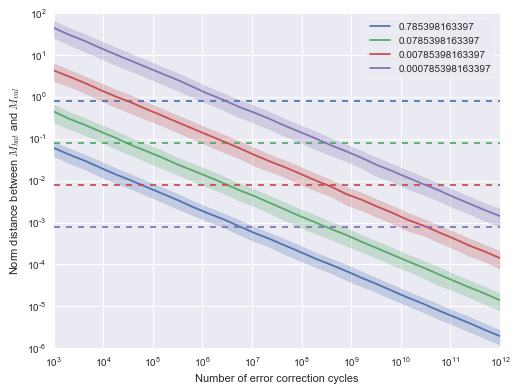

In [11]:
v = df.pivot_table(index="d", columns="n", values="Mdist", aggfunc=np.mean)
s = df.pivot_table(index="d", columns="n", values="Mdist", aggfunc=np.std)
dss = df["d"].unique()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for idx, d in enumerate(dss):
    t = v.loc[d, :].index.values
    y = v.loc[d, :].values
    e = s.loc[d, :].values
    ax.loglog(t, y, c=sns.color_palette()[idx], label=d)
    ax.axhline(d, c=sns.color_palette()[idx], ls="--")
    ax.fill_between(t, y-e, y+e, color=sns.color_palette()[idx], alpha=0.25)
plt.legend(frameon=True)
plt.ylabel("Norm distance between $M_{hat}$ and $M_{val}$")
plt.xlabel("Number of error correction cycles")

In [28]:
for k in range(len(v)):
    x = np.log(v.iloc[k, :].index)
    y = np.log(v.iloc[k, :].values)
    reg = sp.stats.linregress(x, y)
    print "norm_dist = {} e^({}*n) at d = {}".format(np.exp(reg.intercept), reg.slope, v.index[k])

norm_dist = 1406.65857919 e^(-0.500111137911*n) at d = 0.000785398163397
norm_dist = 139.18165334 e^(-0.499518296001*n) at d = 0.00785398163397
norm_dist = 14.0130821627 e^(-0.500022671747*n) at d = 0.0785398163397
norm_dist = 1.92439112492 e^(-0.499977559953*n) at d = 0.785398163397


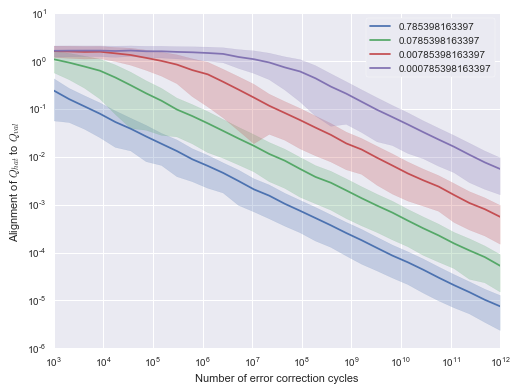

In [9]:
v = df.pivot_table(index="d", columns="n", values="Qalign", aggfunc=np.mean)
s = df.pivot_table(index="d", columns="n", values="Qalign", aggfunc=np.std)
dss = df["d"].unique()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for idx, d in enumerate(dss):
    t = v.loc[d, :].index.values
    y = v.loc[d, :].values
    e = s.loc[d, :].values
    ax.loglog(t, y, c=sns.color_palette()[idx], label=d)
    ax.fill_between(t, y-e, y+e, color=sns.color_palette()[idx], alpha=0.25)
plt.legend(frameon=True)
plt.ylabel("Alignment of $Q_{hat}$ to $Q_{val}$")
plt.xlabel("Number of error correction cycles")